In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
sys.path.append('..')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")
%load_ext line_profiler
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (11,8)

In [3]:
from merf.utils import MERFDataGenerator
from merf.merf import MERF

# Test Data Generation

In [4]:
dgm = MERFDataGenerator(m=.6, sigma_b=np.sqrt(4.5), sigma_e=1)

In [5]:
num_clusters_each_size = 20
train_sizes = [1, 3, 5, 7, 9]
known_sizes = [9, 27, 45, 63, 81]
new_sizes = [10, 30, 50, 70, 90]

In [6]:
# Smaller set that can be used for debugging
# num_clusters_each_size = 1
# train_sizes = [1, 3]
# known_sizes = [9, 27]
# new_sizes = [10, 30]

In [7]:
train_cluster_sizes = MERFDataGenerator.create_cluster_sizes_array(train_sizes, num_clusters_each_size)
known_cluster_sizes = MERFDataGenerator.create_cluster_sizes_array(known_sizes, num_clusters_each_size)
new_cluster_sizes = MERFDataGenerator.create_cluster_sizes_array(new_sizes, num_clusters_each_size)

In [8]:
len(train_cluster_sizes), len(known_cluster_sizes), len(new_cluster_sizes)

(100, 100, 100)

In [9]:
train, test_known, test_new = dgm.generate_split_samples(train_cluster_sizes, known_cluster_sizes, new_cluster_sizes)

INFO     [utils.py:135] Drew 10000 samples from 200 clusters.
INFO     [utils.py:136] PTEV = 90.05180265653775, PREV = 49.712373017476764.


In [10]:
len(train), len(test_known), len(test_new)

(500, 4500, 5000)

In [26]:
train.head()

,y,X_0,X_1,X_2,Z,cluster
0,-2.377293,0.791845,0.367799,-0.122290,1.0,0
10,3.015672,0.305146,0.155170,1.053222,1.0,1
20,-4.115954,-2.523748,0.506494,-0.497001,1.0,2
30,4.124509,1.339381,1.623022,0.256218,1.0,3
40,4.194181,0.985427,0.341255,0.274547,1.0,4


# MERF Training

In [11]:
X_train = train[['X_0', 'X_1', 'X_2']]
Z_train = train[['Z']]
clusters_train = train['cluster']
y_train = train['y']

In [12]:
mrf = MERF(n_estimators=300, max_iterations=20)

In [13]:
mrf.fit(X_train, Z_train, clusters_train, y_train)

INFO     [merf.py:235] GLL is 1080.4132517617604 at iteration 1.
INFO     [merf.py:235] GLL is 854.8739013152039 at iteration 2.
INFO     [merf.py:235] GLL is 832.6398365822145 at iteration 3.
INFO     [merf.py:235] GLL is 825.5836408158829 at iteration 4.
INFO     [merf.py:235] GLL is 833.9980004237696 at iteration 5.
INFO     [merf.py:235] GLL is 829.7630514764616 at iteration 6.
INFO     [merf.py:235] GLL is 822.8171998125989 at iteration 7.
INFO     [merf.py:235] GLL is 815.6921896909339 at iteration 8.
INFO     [merf.py:235] GLL is 816.1144674974033 at iteration 9.
INFO     [merf.py:235] GLL is 831.1245480088452 at iteration 10.
INFO     [merf.py:235] GLL is 834.7217502709793 at iteration 11.
INFO     [merf.py:235] GLL is 828.2781541990128 at iteration 12.
INFO     [merf.py:235] GLL is 831.2153241891576 at iteration 13.
INFO     [merf.py:235] GLL is 829.062980028914 at iteration 14.
INFO     [merf.py:235] GLL is 827.5713608359114 at iteration 15.
INFO     [merf.py:235] GLL is 827.

Text(0.5,0,'Iteration')

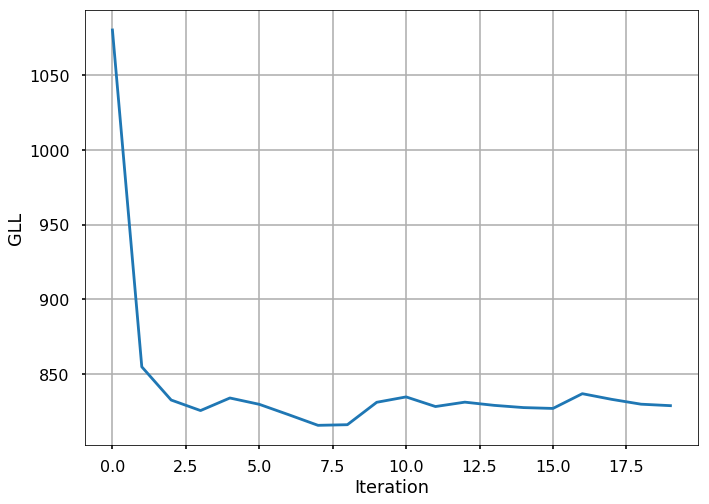

In [14]:
plt.plot(mrf.gll_history)
plt.grid('on')
plt.ylabel('GLL')
plt.xlabel('Iteration')

Text(0.5,0,'Iteration')

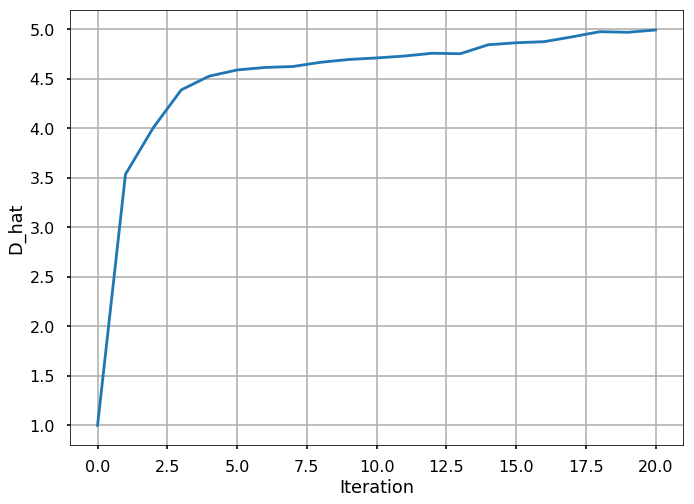

In [15]:
D_hat_history = [x[0][0] for x in mrf.D_hat_history]
plt.plot(D_hat_history)
plt.grid('on')
plt.ylabel('D_hat')
plt.xlabel('Iteration')

Text(0.5,0,'Iteration')

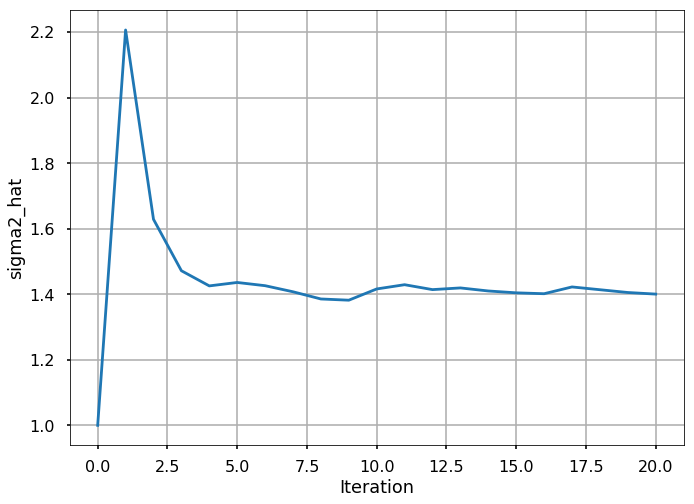

In [16]:
plt.plot(mrf.sigma2_hat_history)
plt.grid('on')
plt.ylabel('sigma2_hat')
plt.xlabel('Iteration')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x111366e10>]], dtype=object)

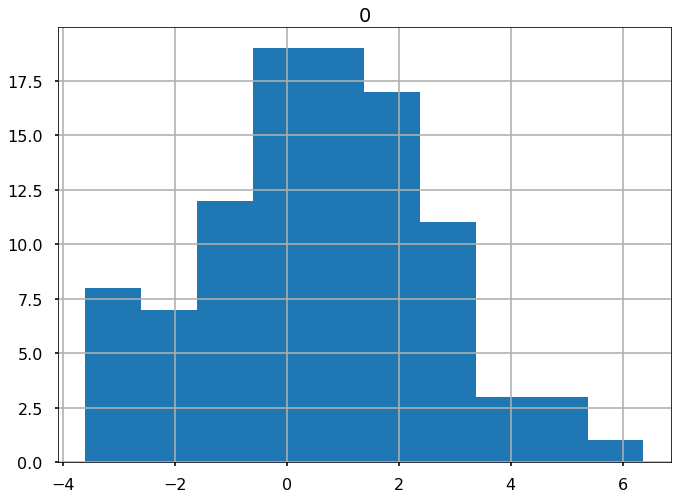

In [19]:
mrf.trained_b.hist(bins=10)

# MERF Prediction

In [20]:
X_known = test_known[['X_0', 'X_1', 'X_2']]
Z_known = test_known[['Z']]
clusters_known = test_known['cluster']
y_known = test_known['y']

In [21]:
y_hat_known = mrf.predict(X_known, Z_known, clusters_known)

In [22]:
assert len(y_hat_known) == len(y_known)

In [23]:
X_new = test_new[['X_0', 'X_1', 'X_2']]
Z_new = test_new[['Z']]
clusters_new = test_new['cluster']
y_new = test_new['y']

In [24]:
y_hat_new = mrf.predict(X_new, Z_new, clusters_new)

In [25]:
assert len(y_hat_new) == len(y_new)

# MERF Accuracy

In [27]:
# Train and test using classic random forest. 
from sklearn.ensemble import RandomForestRegressor
import numpy as np

In [28]:
rf = RandomForestRegressor(n_estimators=300, n_jobs=-1)

In [29]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [30]:
y_hat_known_rf = rf.predict(X_known)

In [31]:
pmse_known_rf = np.mean((y_known - y_hat_known_rf) ** 2)
pmse_known_rf

7.1212236023225675

In [32]:
y_hat_known_merf = mrf.predict(X_known, Z_known, clusters_known)

In [33]:
pmse_known_merf = np.mean((y_known - y_hat_known_merf) ** 2)
pmse_known_merf

2.2329284038486659

In [34]:
rd_known = 100 * (pmse_known_rf - pmse_known_merf) / pmse_known_rf
rd_known

68.644034669541867

In [35]:
y_hat_new_rf = rf.predict(X_new)

In [36]:
pmse_new_rf = np.mean((y_new - y_hat_new_rf) ** 2)
pmse_new_rf

8.0018632866081543

In [37]:
y_hat_new_merf = mrf.predict(X_new, Z_new, clusters_new)

In [38]:
pmse_new_merf = np.mean((y_new - y_hat_new_merf) ** 2)
pmse_new_merf

6.9890072311852576

In [39]:
rd_new = 100 * (pmse_new_rf - pmse_new_merf) / pmse_new_rf
rd_new

12.657752565180704